# Section 6.5.6 Superposition in space using Theis wells

Theis considered the transient flow due to a well with a constant extraction since $t=0$ placed in a uniform confined aquifer of infinite extent.

The solution may be opbtained by straighforward Lapace transformation and looking up de result from the Laplace inversions table. It reads

$$ s(r, t) = \frac Q {4 \pi kD} W(u),\,\,\,\, u = \frac {r^2 S} {4 kD t}$$

where W(..) is the so-called Theis well function, which is actually equal to the mathematical exponential integral

$$ W(z) = \mathtt{exp1}(z) = \intop _z ^\infty \frac {e^{-y}} {y} dy $$

The exponential integral lives in scipy special as the function $\mathtt{exp1}(z)$

After importing this function from the module scipy.special we can use `exp1(u)`



# Task
There are four wells placed on a square with 1 km long sides. The extraction rate is 600 m3/h from each well. However the wells are constructed and started one year after onanother. In order in which they are constructed is NW, NE, SE and SW. Transmissivity is  $kD=600$ m2/d and the specific yield $Sy=0.24$. Visualize the drawdown by these wells as a function of time for a period of 10 years. Show spatial snapshots of the drawdowns as times 0.5, 1.5, 2.5, 45. and 4.5 years after the start of the first injection.

In [112]:
from scipy.special import exp1 as W
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import pdb


def newfig(title, xlabel, ylabel, xlim=None, ylim=None, xscale=None, yscale=None,
           size_inches=(12, 5), fontsize=15):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.grid()
    return ax

attribs = lambda obj: [o for o in dir(obj) if not o.startswith('_')]

How does the drawdown behave for diffent distances from the well?

For this assume a real situation.

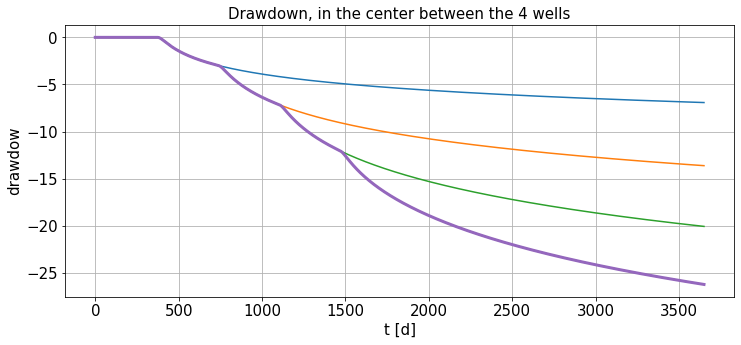

In [113]:
kD = 600 # m2/d
Sy = 0.24 # [-]
L = 1000. # m

u = lambda t, r: r **2 * Sy / (4 * kD * t)

ax = newfig('Drawdown, in the center between the 4 wells', 't [d]', 'drawdow', xscale='linear')

Qs = -np.array([600, 600, 600, 600]) * 24 # m3/d
ts_start = np.array([1, 2, 3, 4]) * 365 # d

t = np.linspace(0, 10, 1001) * 365 # days
s = np.zeros_like(t)
for Q, t_start in zip(Qs, ts_start):
    r = L * np.sqrt(2) / 2
    s[t>t_start] += Q / (4 * np.pi * kD) * W(u(t[t>t_start] - t_start, r))
    ax.plot(t, s)
ax.plot(t, s, lw=3)

# The drawdown contours at 4 times and an animation of the drawdown

In [46]:
columns = ['Id', "x", "y", "Q m3/h", "t_start y"] 
wells = [[1, -500, 500, 60, 0],
         [2, 500, 500, 60, 1],
         [3, 500, -500, 60, 2],
         [4, -500, -500, 60, 3]]
wells = pd.DataFrame(wells, columns=columns)
wells.index = wells["Id"]
wells = wells.drop(columns=["Id"])
wells["Q"] = wells["Q m3/h"] * 24
wells["tstart"] = wells["t_start y"] * 365
wells['r0'] = 0.25


In [47]:
x = np.arange(-750, 751, 50)
y = np.arange(-750, 751, 50)
X, Y = np.meshgrid(x, y)

In [114]:
# Nicer distances between points so that contours are round around wells
xx = np.logspace(0, np.log10(500), 20)
x = np.unique(np.hstack((-xx[::-1] - 500, xx - 500, -xx[::-1] + 500, xx + 500)))
y = x[:]
X, Y = np.meshgrid(x, y)

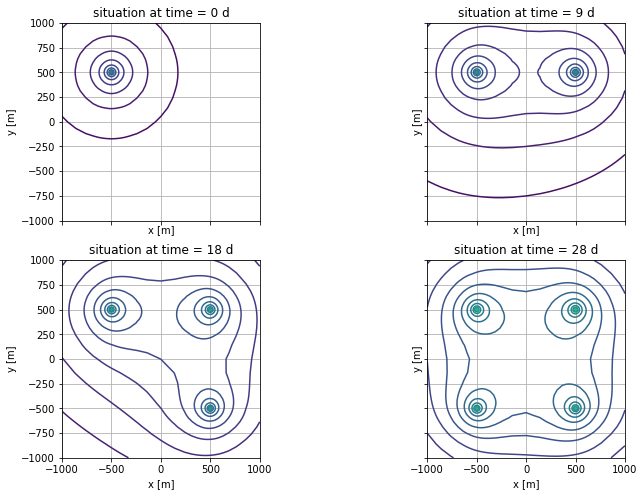

In [131]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 8)
axs = axs.flatten()

for ax, t in zip(axs, times):
    ax.set_title("situation at time = {:.0f} d".format(t))
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.grid()
    ax.set_aspect(1.)

u = lambda R, t: R ** 2 * Sy  / (4 * kD * t)

times = wells['tstart'].values + 180

s = np.zeros((len(times), len(y), len(x)))
for Id in wells.index:
    well = wells.loc[Id]
    R = np.sqrt((X - well['x']) ** 2 + (Y - well['y']) ** 2)
    R = np.fmax(well["r0"], R)
    for it, t in enumerate(times):
        if t > well["tstart"]:
            s[it] += well["Q"] / (4 * np.pi * kD) * W(u(R, t - well["tstart"]))        
    #print(np.max(s[it]))

levels = np.arange(0, 5, 0.2)

for it, (t, ax) in enumerate(zip(times, axs)):
    cont = ax.contour(X, Y, s[it], levels=levels)
    

# Animation

In [128]:
ttl = "kD = {:.0f} m2/d, Sy = {:.2f}, Q = {:.0f} m3/d per well.".format(kD, Sy, wells.iloc[0]["Q"])

ax = newfig("Drawdown over time, " + ttl, "x [m]", "y [m]", size_inches=(10,  8), fontsize=15)
fig = ax.figure
ax.set_aspect(1.0)

u = lambda R, t: R ** 2 * Sy  / (4 * kD * t)

times = wells['tstart'].values + 180
times = np.linspace(0, 5, 200) * 365.

for Id in wells.index:
    well = wells.loc[Id]
    ax.plot(well["x"], well["y"], 'ro')
    ax.text(well["x"], well["y"], "  well {}, tstart={:.0f} d".format(Id, well["tstart"]))

R = list()
for Id in wells.index:
    well = wells.loc[Id]
    r = np.sqrt((X - well['x']) ** 2 + (Y - well['y']) ** 2)
    R.append(np.fmax(well["r0"], r))

s = np.zeros((len(times), len(y), len(x)))

for it, t in enumerate(times):
    for iw in range(len(wells)):
        well = wells.iloc[iw]
        if t > well["tstart"]:
            s[it] += well["Q"] / (4 * np.pi * kD) * W(u(R[iw], t - well["tstart"]))        
        #print(np.max(s[it]))

cvals = np.arange(0, 5.1, 0.2)
cont = ax.contour(x, y, s[0], levels=cvals)
ttxt = ax.text(0.5, 0.5, "time = {:5.0f} d".format(0), ha="center", va="center", transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='wheat'), fontsize=15)

def init():
    global cont, s
    return cont.collections + [ttxt]

clrs = 'brgkmcy' 
def animate(it):
    global cont, s, times
    for tp in cont.collections:
        tp.remove()
    cont= ax.contour(x, y, s[it], levels=cvals, colors='k')
    ttxt.set_text("time = {:5.0f} d".format(times[it]))
    return cont.collections + [ttxt]


anim = FuncAnimation(fig, animate, frames=len(times),
                                  fargs=(), init_func=init, interval=100, blit=True, repeat=False)

plt.close(anim._fig)
out = HTML(anim.to_html5_video())
#out # to actually show the video.

/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: No contour levels were found within the data range.
/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: No contour levels were found within the data range.


In [129]:
fname = "FourWellsContours"
anim.save(fname + '.mp4', fps=20, extra_args=['-vcodec', 'libx264'], bitrate=1000)
print(anim.save_count, " frames saved.") # Shows the number of frames saved.

/Users/Theo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: No contour levels were found within the data range.


200  frames saved.


In [130]:
!ffmpeg -i FourWellsContours.mp4 -y FourWellsContours.gif

ffmpeg version 3.2.1 Copyright (c) 2000-2016 the FFmpeg developers
  built with llvm-gcc 4.2.1 (LLVM build 2336.11.00)
  configuration: --prefix=/Volumes/Ramdisk/sw --enable-gpl --enable-pthreads --enable-version3 --enable-libspeex --enable-libvpx --disable-decoder=libvpx --enable-libmp3lame --enable-libtheora --enable-libvorbis --enable-libx264 --enable-avfilter --enable-libopencore_amrwb --enable-libopencore_amrnb --enable-filters --enable-libgsm --enable-libvidstab --enable-libx265 --disable-doc --arch=x86_64 --enable-runtime-cpudetect
  libavutil      55. 34.100 / 55. 34.100
  libavcodec     57. 64.101 / 57. 64.101
  libavformat    57. 56.100 / 57. 56.100
  libavdevice    57.  1.100 / 57.  1.100
  libavfilter     6. 65.100 /  6. 65.100
  libswscale      4.  2.100 /  4.  2.100
  libswresample   2.  3.100 /  2.  3.100
  libpostproc    54.  1.100 / 54.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'FourWellsContours.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 5

In [86]:
attribs(cont)

['add_checker',
 'add_label',
 'add_label_clabeltext',
 'add_label_near',
 'allkinds',
 'allsegs',
 'alpha',
 'antialiased',
 'autoscale',
 'autoscale_None',
 'ax',
 'axes',
 'calc_label_rot_and_inline',
 'callbacksSM',
 'changed',
 'check_update',
 'clabel',
 'cmap',
 'collections',
 'colorbar',
 'colors',
 'cvalues',
 'extend',
 'extent',
 'filled',
 'find_nearest_contour',
 'get_alpha',
 'get_array',
 'get_clim',
 'get_cmap',
 'get_label_coords',
 'get_label_width',
 'get_text',
 'get_transform',
 'hatches',
 'labelCValues',
 'labelTexts',
 'labels',
 'layers',
 'legend_elements',
 'levels',
 'linestyles',
 'linewidths',
 'locate_label',
 'locator',
 'logscale',
 'monochrome',
 'nchunk',
 'norm',
 'origin',
 'pop_label',
 'print_label',
 'set_alpha',
 'set_array',
 'set_clim',
 'set_cmap',
 'set_label_props',
 'set_norm',
 'stale',
 'tcolors',
 'tlinewidths',
 'to_rgba',
 'too_close',
 'update_dict',
 'zmax',
 'zmin']

In [89]:
cont.levels

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

In [90]:
cont.colors

'k'

In [91]:
cont.set_array()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

In [92]:
s[4]

array([[3.25516032e-05, 3.61406562e-05, 3.92078874e-05, 4.15593941e-05,
        4.30385166e-05, 4.35433439e-05, 4.30385166e-05, 4.15593941e-05,
        3.92078874e-05, 3.61406562e-05, 3.25516032e-05, 2.86514294e-05,
        2.46472698e-05, 2.07251178e-05, 1.70369783e-05, 1.36936923e-05,
        1.07633667e-05, 8.27452977e-06, 6.22263050e-06, 4.57832929e-06,
        3.29615282e-06, 2.32240243e-06, 1.60161095e-06, 1.08124051e-06,
        7.14638037e-07, 4.62485011e-07, 2.93090959e-07, 1.81904011e-07,
        1.10574642e-07, 6.58380723e-08, 3.84006514e-08],
       [5.76427947e-05, 6.40574964e-05, 6.95451809e-05, 7.37556553e-05,
        7.64055029e-05, 7.73101447e-05, 7.64055029e-05, 7.37556553e-05,
        6.95451809e-05, 6.40574964e-05, 5.76427947e-05, 5.06807170e-05,
        4.35433439e-05, 3.65634661e-05, 3.00116407e-05, 2.40836652e-05,
        1.88982444e-05, 1.45031557e-05, 1.08873250e-05, 7.99597224e-06,
        5.74624374e-06, 4.04136030e-06, 2.78205869e-06, 1.87482458e-06,
       